Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [X] Choose your target. Which column in your tabular dataset will you predict?
- [X] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [X] Determine whether your problem is regression or classification.
- [X] Choose your evaluation metric.
- [X] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [X] Begin to clean and explore your data.
- [X] Choose which features, if any, to exclude. Would some features "leak" information from the future?

## Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), **by Lambda DS3 student** Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)

In [1]:
# Load the data so we can use it
import pandas as pd
bitcoin = pd.read_csv('Historical data for Bitcoin.csv')
bitcoin.head(10)

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,8/12/2019,11528.19,11528.19,11320.95,11382.62,1.364720e+10,2.034410e+11
1,8/11/2019,11349.74,11523.58,11248.29,11523.58,1.577437e+10,2.059420e+11
2,8/10/2019,11861.56,11915.66,11323.90,11354.02,1.812536e+10,2.028900e+11
3,8/9/2019,11953.47,11970.46,11709.75,11862.94,1.833999e+10,2.119610e+11
4,8/8/2019,11954.04,11979.42,11556.17,11966.41,1.948159e+10,2.137880e+11
5,8/7/2019,11476.19,12036.99,11433.70,11941.97,2.219499e+10,2.133300e+11
6,8/6/2019,11811.55,12273.82,11290.73,11478.17,2.363511e+10,2.050230e+11
7,8/5/2019,10960.74,11895.09,10960.74,11805.65,2.387599e+10,2.108490e+11
8,8/4/2019,10821.63,11009.21,10620.28,10970.18,1.653089e+10,1.959080e+11
9,8/3/2019,10519.28,10946.78,10503.50,10821.73,1.535269e+10,1.932340e+11


In [2]:
bitcoin.dtypes

Date           object
Open*         float64
High          float64
Low           float64
Close**       float64
Volume        float64
Market Cap    float64
dtype: object

In [3]:
from tqdm import tnrange
# A little bit of feature engineering

bitcoin['Previous higher?'] = ""

for i in tnrange(len(bitcoin)-1,0,-1):
    if(i>0):
        bitcoin['Previous higher?'][i-1] = bitcoin['Low'][i].copy() > bitcoin['Low'][i-1].copy()
    bitcoin['Previous higher?'][2297] = False

C:\Users\Samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [4]:
# A little more feature engineering
bitcoin['numeric_date'] = bitcoin['Date'].copy()

bitcoin['avg_daily_price'] = (bitcoin['Open*']+bitcoin['High']+bitcoin['Low']+bitcoin['Close**'])/4

bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin['Year'] = bitcoin['Date'].dt.year
bitcoin['Month'] = bitcoin['Date'].dt.month
bitcoin['Day'] = bitcoin['Date'].dt.day

In [5]:
# Change True/False to 1/0
new_columns = {True: 1, False:0}
bitcoin['Previous higher?'] = [new_columns[item] for item in bitcoin['Previous higher?']]

In [6]:
train = bitcoin[bitcoin.Year < 2016]
val = bitcoin[(bitcoin.Year >2015) & (bitcoin.Year < 2018)]
test = bitcoin[bitcoin.Year > 2017]

In [76]:
# Get the X and y parts for train, val, and test
drop_columns = ['Previous higher?','Date','Close**']
target = 'Previous higher?'
X_train = train.drop(columns=drop_columns)
y_train = train[target]
X_val = val.drop(columns=drop_columns)
y_val = val[target]
X_test = test.drop(columns=drop_columns)
y_test = test[target]

This is a regression problem.

In [77]:
accuracy = y_train.value_counts(normalize=True)[0]
print('Accuracy is', accuracy)

Accuracy is 0.5715746421267893


In [78]:
bitcoin.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap,Previous higher?,numeric_date,avg_daily_price,Year,Month,Day,log(Bitcoin Close)
0,2019-08-12,11528.19,11528.19,11320.95,11382.62,1.364720e+10,2.034410e+11,0,8/12/2019,11439.9875,2019,8,12,9.339931
1,2019-08-11,11349.74,11523.58,11248.29,11523.58,1.577437e+10,2.059420e+11,1,8/11/2019,11411.2975,2019,8,11,9.352237
2,2019-08-10,11861.56,11915.66,11323.90,11354.02,1.812536e+10,2.028900e+11,1,8/10/2019,11613.7850,2019,8,10,9.337415
3,2019-08-09,11953.47,11970.46,11709.75,11862.94,1.833999e+10,2.119610e+11,0,8/9/2019,11874.1550,2019,8,9,9.381259
4,2019-08-08,11954.04,11979.42,11556.17,11966.41,1.948159e+10,2.137880e+11,0,8/8/2019,11864.0100,2019,8,8,9.389942


Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Plot the distribution of your target. 
    - Regression problem: Is your target skewed? Then, log-transform it.
    - Classification: Are your classes imbalanced? Then, don't use just accuracy. And try `class_balance` parameter in scikit-learn.
- [X] Continue to clean and explore your data. Make exploratory visualizations.
- [X] Fit a model. Does it beat your baseline?
- [X] Share at least 1 visualization on Slack.

You need to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

### Today
- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)


### Yesterday
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), **by Lambda DS3 student** Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)

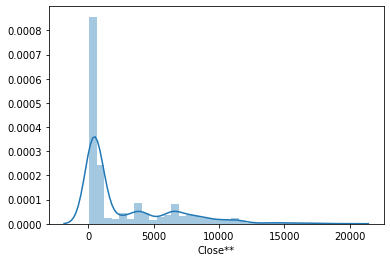

In [79]:
import seaborn as sns
y = bitcoin['Close**']
sns.distplot(y);

In [80]:
import numpy as np
y_log = np.log1p(y)
bitcoin['log(Bitcoin Close)'] = y_log

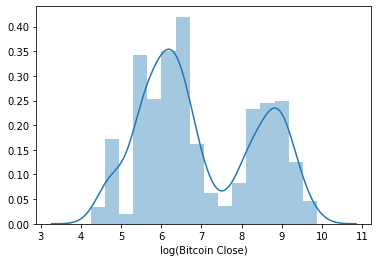

In [81]:
sns.distplot(bitcoin['log(Bitcoin Close)']);

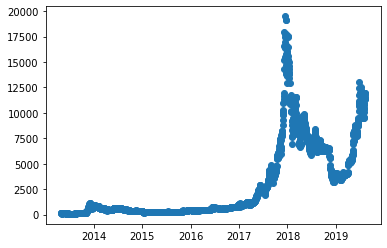

In [82]:
import matplotlib.pyplot as plt
import matplotlib

dates = matplotlib.dates.date2num(bitcoin['Date'])
plt.plot_date(dates, bitcoin['Close**']);

In [83]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [84]:
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6826265389876881


In [85]:
bitcoin.dtypes

Date                  datetime64[ns]
Open*                        float64
High                         float64
Low                          float64
Close**                      float64
Volume                       float64
Market Cap                   float64
Previous higher?               int64
numeric_date                  object
avg_daily_price              float64
Year                           int64
Month                          int64
Day                            int64
log(Bitcoin Close)           float64
dtype: object

In [86]:
bitcoin.head(10)

,Date,Open*,High,Low,Close**,Volume,Market Cap,Previous higher?,numeric_date,avg_daily_price,Year,Month,Day,log(Bitcoin Close)
0,2019-08-12,11528.19,11528.19,11320.95,11382.62,1.364720e+10,2.034410e+11,0,8/12/2019,11439.9875,2019,8,12,9.339931
1,2019-08-11,11349.74,11523.58,11248.29,11523.58,1.577437e+10,2.059420e+11,1,8/11/2019,11411.2975,2019,8,11,9.352237
2,2019-08-10,11861.56,11915.66,11323.90,11354.02,1.812536e+10,2.028900e+11,1,8/10/2019,11613.7850,2019,8,10,9.337415
3,2019-08-09,11953.47,11970.46,11709.75,11862.94,1.833999e+10,2.119610e+11,0,8/9/2019,11874.1550,2019,8,9,9.381259
4,2019-08-08,11954.04,11979.42,11556.17,11966.41,1.948159e+10,2.137880e+11,0,8/8/2019,11864.0100,2019,8,8,9.389942
5,2019-08-07,11476.19,12036.99,11433.70,11941.97,2.219499e+10,2.133300e+11,0,8/7/2019,11722.2125,2019,8,7,9.387898
6,2019-08-06,11811.55,12273.82,11290.73,11478.17,2.363511e+10,2.050230e+11,0,8/6/2019,11713.5675,2019,8,6,9.348289
7,2019-08-05,10960.74,11895.09,10960.74,11805.65,2.387599e+10,2.108490e+11,0,8/5/2019,11405.5550,2019,8,5,9.376418
8,2019-08-04,10821.63,11009.21,10620.28,10970.18,1.653089e+10,1.959080e+11,0,8/4/2019,10855.3250,2019,8,4,9.303027
9,2019-08-03,10519.28,10946.78,10503.50,10821.73,1.535269e+10,1.932340e+11,0,8/3/2019,10697.8225,2019,8,3,9.289404


Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [87]:
import numpy as np

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

In [88]:
from xgboost import XGBRegressor 
from sklearn.metrics import r2_score

new_pipe = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=300, objective='reg:squarederror', n_jobs=-1)
)

new_pipe.fit(X_train, y_train_log)
y_pred_log = new_pipe.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(r2_score(y_val, y_pred))

-0.16615772365377923


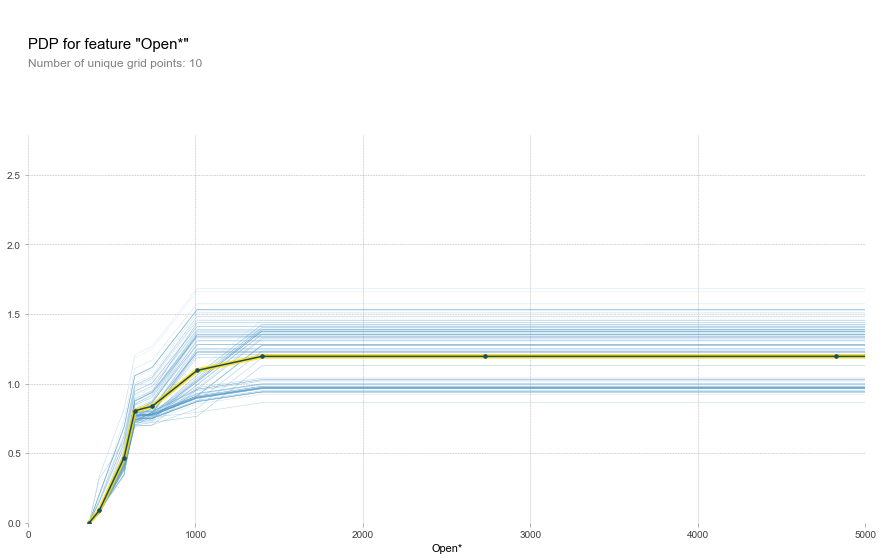

In [89]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Open*'

isolated = pdp_isolate(
    model=new_pipe,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
#    num_grid_points=10
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,5000);

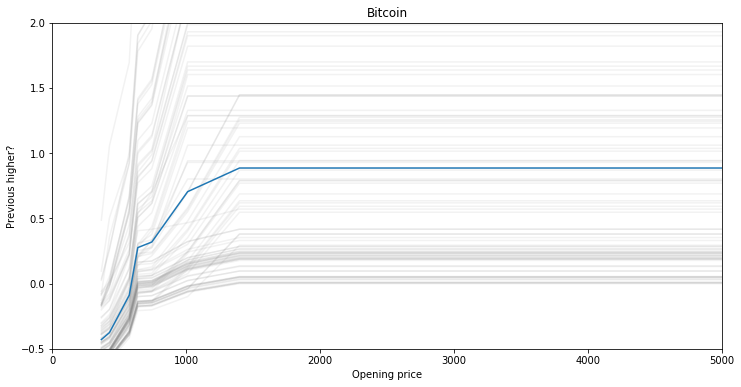

In [90]:
import matplotlib.pyplot as plt
grid = isolated.feature_grids

ice_log = isolated.ice_lines.sample(n=100).T
ice = ice_log.apply(np.expm1)

pdp_log = isolated.pdp
pdp = np.expm1(pdp_log)

ice.plot(color='gray', alpha=0.1, legend=False, figsize=(12,6));

plt.plot(grid,pdp)
plt.xlim(0,5000)
plt.ylim(-0.5,2)
plt.xlabel('Opening price')
plt.ylabel('Previous higher?')
plt.title('Bitcoin');

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 4

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [X] Make a Shapley force plot to explain at least 1 individual prediction.
- [X] Share at least 1 visualization on Slack.

(If you haven't completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [91]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=bitcoin.Date,
                y=bitcoin['High'],
                name='BTC High',
                line_color = 'green',
                opacity=0.8)
             )

fig.add_trace(go.Scatter(
                x=bitcoin.Date,
                y=bitcoin['Low'],
                name='BTC Low',
                line_color = 'red',
                opacity=0.8)
             )

fig.update_layout(xaxis_range=['2013-04-28','2019-08-12'],
                 title_text='Bitcoin Historical Data')

fig.show();

In [92]:
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train),
           (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed,y_train, eval_set=eval_set, eval_metric='auc',
         early_stopping_rounds=10)

[0]	validation_0-auc:0.616452	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.653938	validation_1-auc:0.542108
[2]	validation_0-auc:0.683523	validation_1-auc:0.553478
[3]	validation_0-auc:0.685871	validation_1-auc:0.552532
[4]	validation_0-auc:0.688487	validation_1-auc:0.552532
[5]	validation_0-auc:0.701741	validation_1-auc:0.546169
[6]	validation_0-auc:0.701301	validation_1-auc:0.546169
[7]	validation_0-auc:0.709003	validation_1-auc:0.559322
[8]	validation_0-auc:0.714878	validation_1-auc:0.555908
[9]	validation_0-auc:0.740085	validation_1-auc:0.564713
[10]	validation_0-auc:0.745734	validation_1-auc:0.564062
[11]	validation_0-auc:0.748667	validation_1-auc:0.569445
[12]	validation_0-auc:0.76162	validation_1-auc:0.569732
[13]	validation_0-auc:0.764122	validation_1-auc:0.570882
[14]	validation_0-auc:0.769103	validation_1-auc:0.570417
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [93]:
# Have pandas help us 
# pick a random row from the test
X_test_random = X_test.sample(n=1)
print(X_test_random)

       Open*     High      Low        Volume    Market Cap numeric_date  \
159  3897.08  3919.51  3871.46  9.175292e+09  6.860989e+10     3/6/2019   

     avg_daily_price  Year  Month  Day  
159        3897.9975  2019      3    6  


In [94]:
# Save the random row
row = X_test.iloc[[204]]

In [95]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)